In [ ]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [ ]:
!kaggle datasets download -d utkarshsaxenadn/fast-food-classification-dataset
!unzip fast-food-classification-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/utkarshsaxenadn/fast-food-classification-dataset
License(s): CC0-1.0
fast-food-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  fast-food-classification-dataset.zip
replace Fast Food Classification V2/TFRecords/Test/Baked Potato_1.tfrecord? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


**Load Datasets**

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, directory):
        self.directory = directory
        self.images = []
        self.labels = []
        self.class_names = sorted(os.listdir(directory))  # Sorted for consistent labels
        self.class_to_index = {class_name: i for i, class_name in enumerate(self.class_names)}

        for class_name in self.class_names:
            class_path = os.path.join(directory, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    try:
                        image = Image.open(img_path).convert('RGB')
                        image = image.resize((224, 224))  # Resize image to 224x224
                        self.images.append((image, self.class_to_index[class_name]))  # Append (image, label)
                    except Exception as e:
                        print(f"Error loading image {img_name}: {e}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image, label = self.images[idx]
        image = np.array(image).astype(np.float32) / 255.0  # Normalize pixel values to [0,1]
        image = torch.tensor(image).permute(2, 0, 1)  # Convert to Tensor and reorder dimensions (C, H, W)
        return image, label

In [ ]:
# Directory setup
dataset_dir = '/content/Fast Food Classification V2'
train_dir = os.path.join(dataset_dir, 'Train')
valid_dir = os.path.join(dataset_dir, 'Valid')

In [ ]:
# Create Datasets and Loaders
train_dataset = CustomImageDataset(train_dir)
valid_dataset = CustomImageDataset(valid_dir)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


**ResNet18**

In [ ]:
resnet_model = models.resnet18(pretrained=True).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Freeze all layers
for param in resnet_model.parameters():
    param.requires_grad = False

In [ ]:
# Modify the final layer to match the number of classes
num_classes = len(train_dataset.class_names)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)  # New output layer
resnet_model.fc = resnet_model.fc.cuda()

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)

In [ ]:
# Training Loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
num_epochs = 10

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()  # Zero gradients

        outputs = resnet_model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Store training loss and accuracy
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

    # Validation Loop
    resnet_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.cuda(), labels.cuda()

            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(valid_loader)
    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Store validation loss and accuracy
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

Epoch [1/10], Loss: 1.0831, Accuracy: 67.25%
Validation Loss: 0.8979, Validation Accuracy: 73.09%
Epoch [2/10], Loss: 0.7309, Accuracy: 77.01%
Validation Loss: 0.8302, Validation Accuracy: 75.06%
Epoch [3/10], Loss: 0.6740, Accuracy: 78.73%
Validation Loss: 0.8022, Validation Accuracy: 75.83%
Epoch [4/10], Loss: 0.6409, Accuracy: 79.66%
Validation Loss: 0.7970, Validation Accuracy: 76.14%
Epoch [5/10], Loss: 0.6175, Accuracy: 80.56%
Validation Loss: 0.8268, Validation Accuracy: 75.23%
Epoch [6/10], Loss: 0.6121, Accuracy: 80.79%
Validation Loss: 0.7992, Validation Accuracy: 76.14%
Epoch [7/10], Loss: 0.6030, Accuracy: 80.87%
Validation Loss: 0.7808, Validation Accuracy: 76.77%
Epoch [8/10], Loss: 0.5960, Accuracy: 80.97%
Validation Loss: 0.7664, Validation Accuracy: 77.63%
Epoch [9/10], Loss: 0.5897, Accuracy: 81.32%
Validation Loss: 0.7762, Validation Accuracy: 76.86%
Epoch [10/10], Loss: 0.5859, Accuracy: 81.21%
Validation Loss: 0.7784, Validation Accuracy: 76.94%


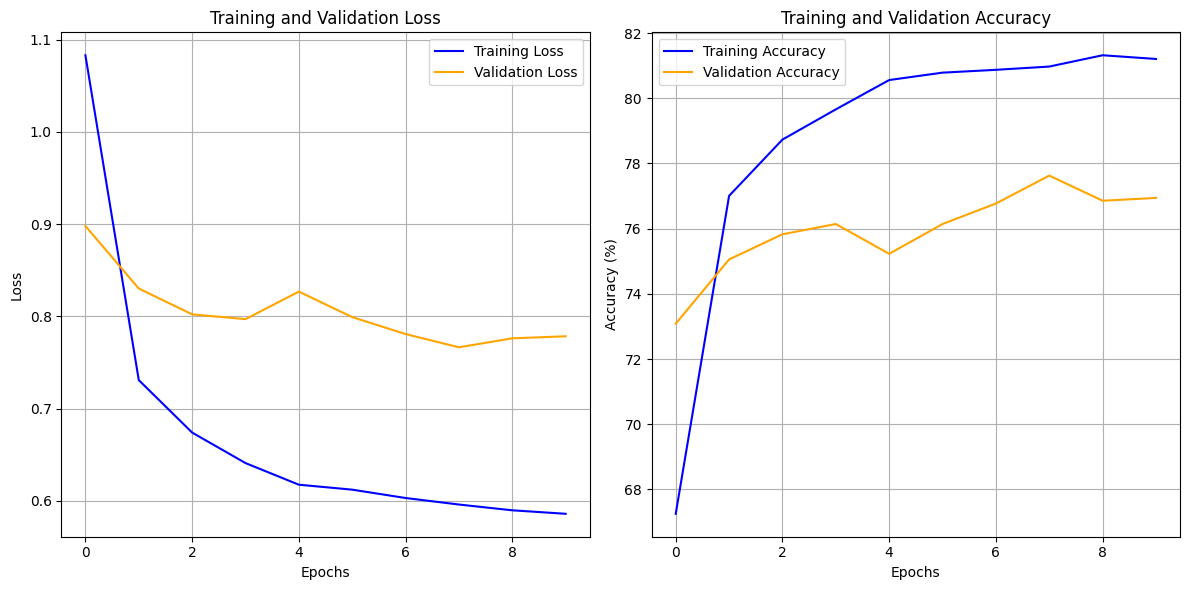

In [ ]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

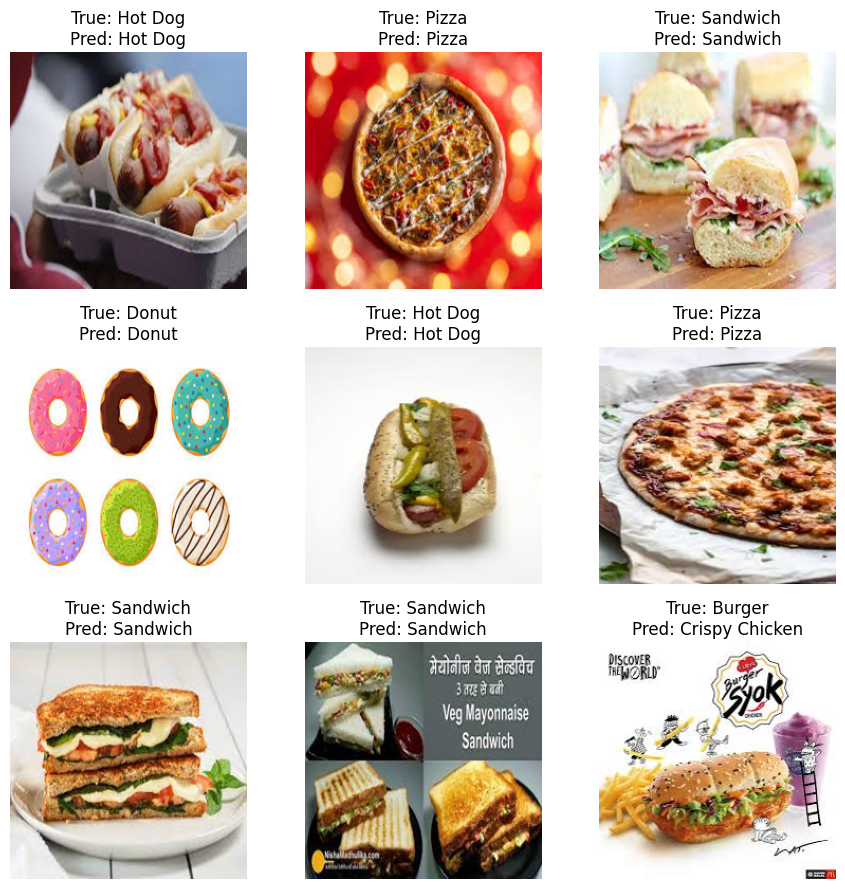

Test Accuracy: 79.60%


In [ ]:
# Test dataset and loader
test_dir = os.path.join(dataset_dir, 'Test')
test_dataset = CustomImageDataset(test_dir)
test_loader = DataLoader(test_dataset, batch_size=32)

# Prediction function for the test set
def predict_images(model, loader, class_names):
    model.eval()
    predictions = []
    true_labels = []
    images_list = []

    with torch.no_grad():  # Disable gradient computation for inference
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)  # Forward pass

            _, predicted = torch.max(outputs, 1)  # Get the index of the highest probability class
            predictions.extend(predicted.cpu().numpy())  # Store the predictions
            true_labels.extend(labels.cpu().numpy())  # Store the true labels
            images_list.extend(images.cpu())  # Store the images for visualization

    return predictions, true_labels, images_list

# Call the prediction function
predictions, true_labels, test_images = predict_images(resnet_model, test_loader, test_dataset.class_names)

# Show a few test images with predicted labels
num_samples_to_show = 9
random_indices = random.sample(range(len(test_images)), num_samples_to_show)

fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()

for ax, idx in zip(axes, random_indices):
    image = test_images[idx]
    image = image.permute(1, 2, 0).numpy()  # Convert tensor to numpy format
    image = np.clip(image, 0, 1)  # Ensure pixel values are in range [0, 1]

    true_label = true_labels[idx]
    predicted_label = predictions[idx]

    ax.imshow(image)
    ax.set_title(f"True: {test_dataset.class_names[true_label]}\nPred: {test_dataset.class_names[predicted_label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Calculate and print accuracy on the test set
correct_predictions = sum([1 if p == t else 0 for p, t in zip(predictions, true_labels)])
test_accuracy = correct_predictions / len(true_labels) * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

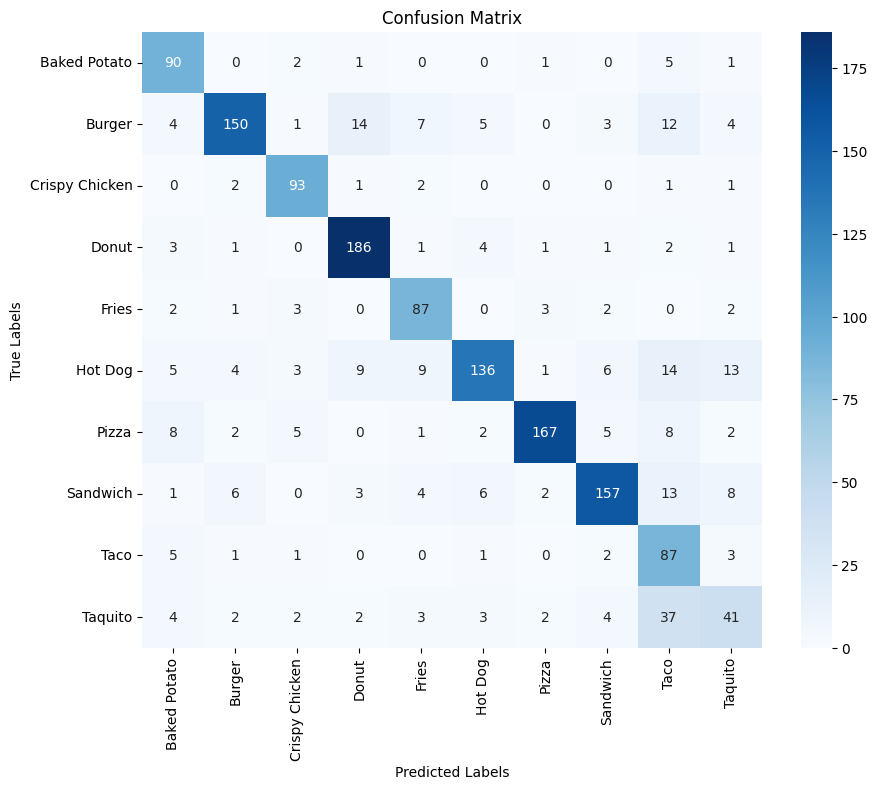

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_dataset.class_names, yticklabels=test_dataset.class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()